# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import os
from shutil import copyfile

In [3]:
from neuralart.data import *

# Get Data

In [13]:
chan_csv_path = "../raw_data/wikiart/csv_chan"
chan_image_path= "../raw_data/wikiart/dataset_chan"
output_path = "../raw_data/wikiart"
dataset_dir_name = 'dataset'

In [5]:
data_full = get_data(chan_csv_path, chan_image_path, rm_image_duplicate=False)
data_full.shape

(81446, 10)

In [6]:
data = get_data(chan_csv_path, chan_image_path, rm_image_duplicate=True)
data.shape

(78748, 10)

In [37]:
merge_mov1={'name': 'merge_mov1',
            'merging':{'abstract_expressionism': None,
                 'action_painting': None,
                 'analytical_cubism': None,
                 'art_nouveau_modern': 'art_nouveau_modern',
                 'baroque': 'baroque',
                 'color_field_painting': None,
                 'contemporary_realism': None,
                 'cubism': None,
                 'early_renaissance': 'early_renaissance',
                 'expressionism': 'expressionism',
                 'fauvism': None,
                 'high_renaissance': 'high_renaissance',
                 'impressionism': 'impressionism',
                 'mannerism_late_renaissance': 'mannerism_late_renaissance',
                 'minimalism': None,
                 'naive_art_primitivism': 'naive_art_primitivism',
                 'new_realism': None,
                 'northern_renaissance': 'northern_renaissance',
                 'pointillism': None,
                 'pop_art': None,
                 'post_impressionism': 'post_impressionism',
                 'realism': 'realism',
                 'rococo': 'rococo',
                 'romanticism': 'romanticism',
                 'symbolism': 'symbolism',
                 'synthetic_cubism': None,
                 'ukiyo_e': 'ukiyo_e'}}

In [39]:
for n in [100,1000,None]:
    for s in ['drop','max']:
        for k in [False, True]:
            for c in [merge_mov1, None]:
                get_dataset(data, target="movement", class_=c, n=n, strategy=s, 
                            random_state=123, output_path=output_path, keep_genre=k )


In [12]:
create_dataset_directory(data_full, chan_image_path, output_path, dataset_dir_name)

2500 images copied
5000 images copied
7500 images copied
10000 images copied
12500 images copied
15000 images copied
17500 images copied
20000 images copied
22500 images copied
25000 images copied
27500 images copied
30000 images copied
32500 images copied
35000 images copied
37500 images copied
40000 images copied
42500 images copied
45000 images copied
47500 images copied
50000 images copied
52500 images copied
55000 images copied
57500 images copied
60000 images copied
62500 images copied
65000 images copied
67500 images copied
70000 images copied
72500 images copied
75000 images copied
77500 images copied
80000 images copied
Done: 81446 image(s) copied, 81446 image(s) in the folder


# Data Visualization

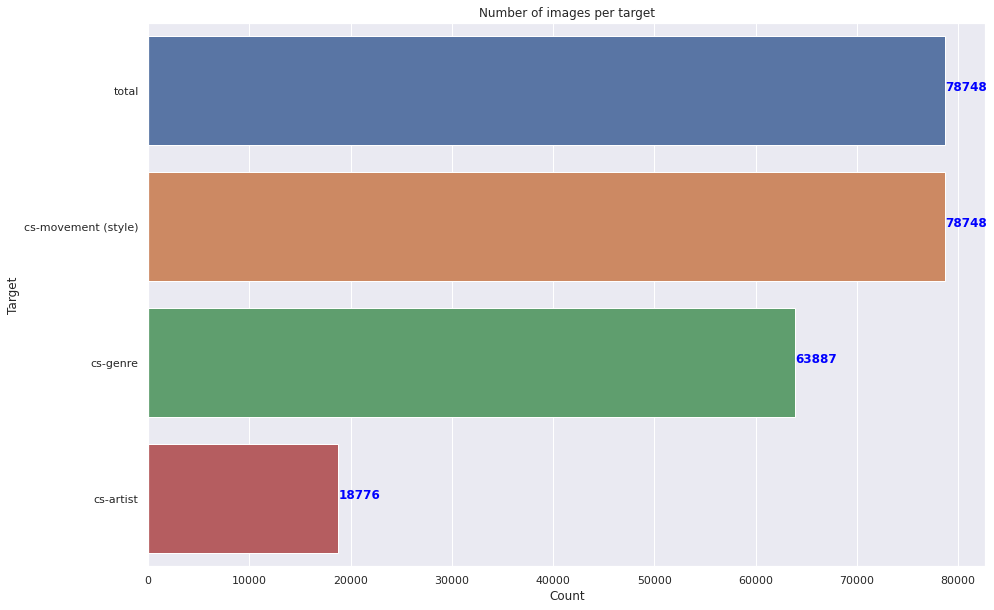

In [16]:
col = ['cs_split_artist','cs_split_genre','cs_split_style','cs_path']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].count().index, 
            x=data[col].count().values,
            order=data[col].count().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].count().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_yticklabels(['total','cs-movement (style)','cs-genre','cs-artist']);
ax.set_title("Number of images per target");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

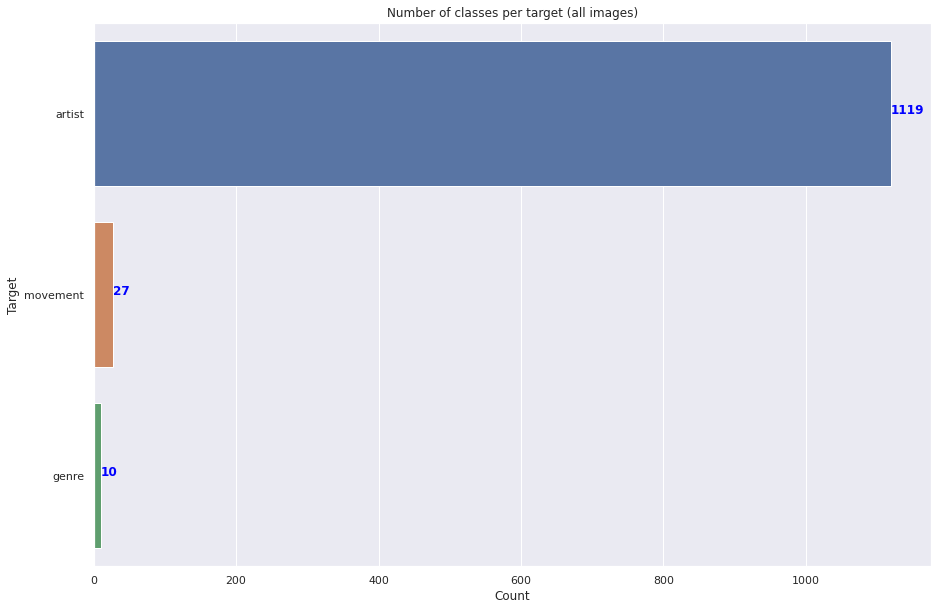

In [17]:
col = ['artist','genre','movement']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].nunique().index, 
            x=data[col].nunique().values,
            order=data[col].nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of classes per target (all images)");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

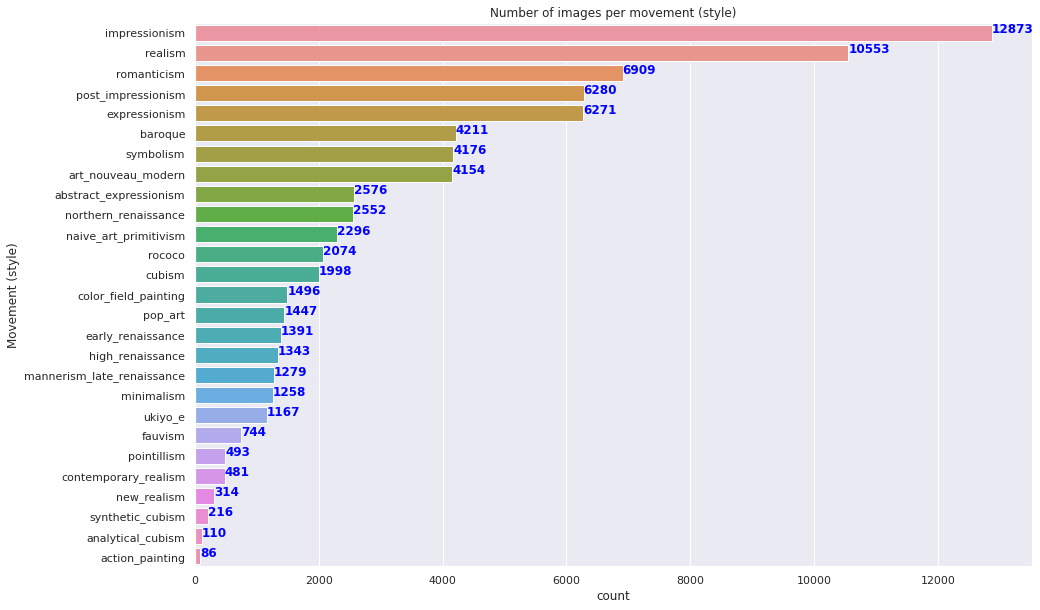

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="movement", 
              order = data['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per movement (style)");
ax.set_ylabel("Movement (style)");

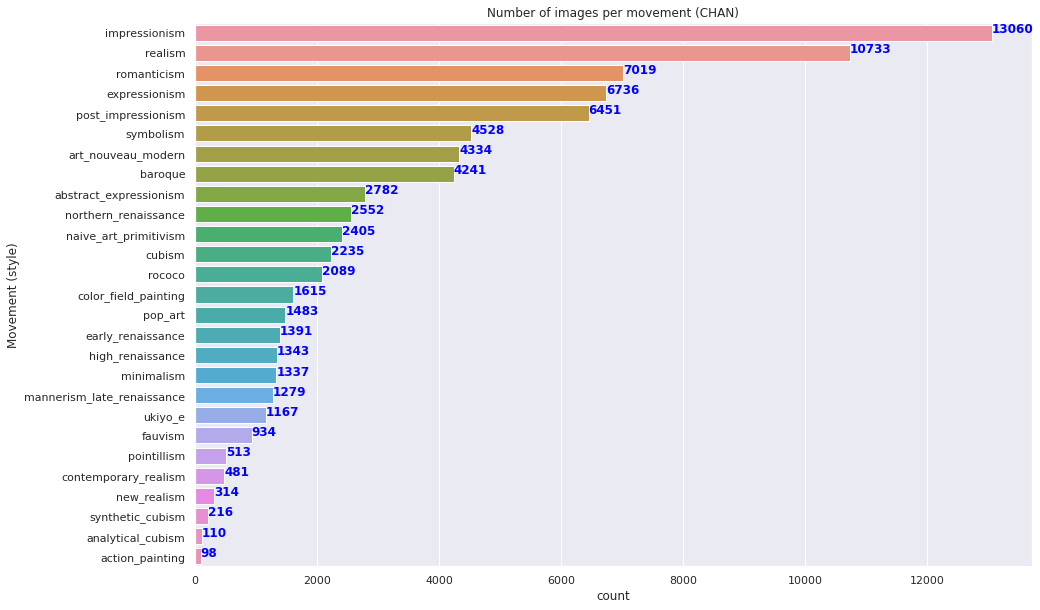

In [20]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data_full, y="movement", 
              order = data_full['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data_full["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per movement (CHAN)");
ax.set_ylabel("Movement (style)");

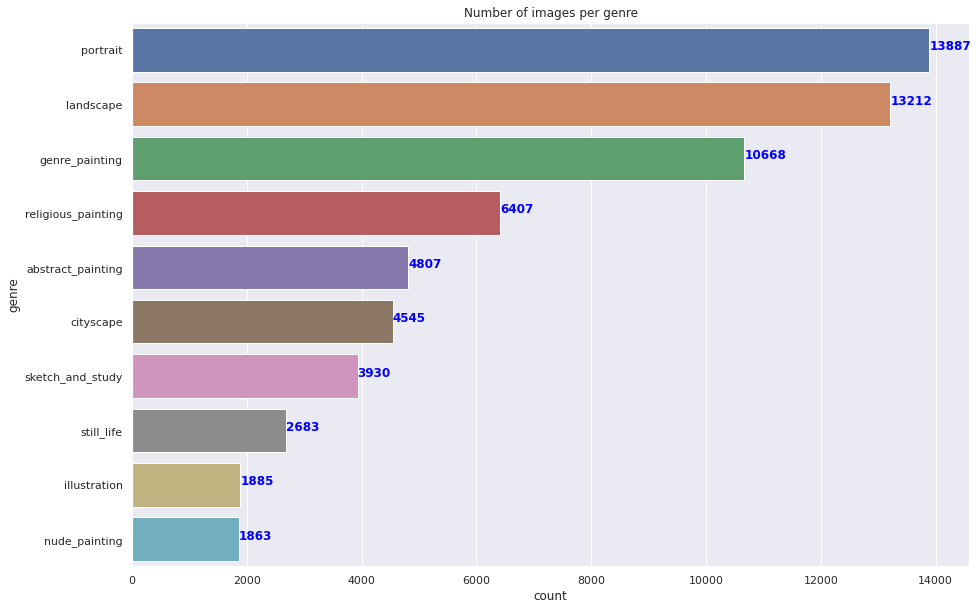

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="genre", 
              order = data['genre'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["genre"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per genre");

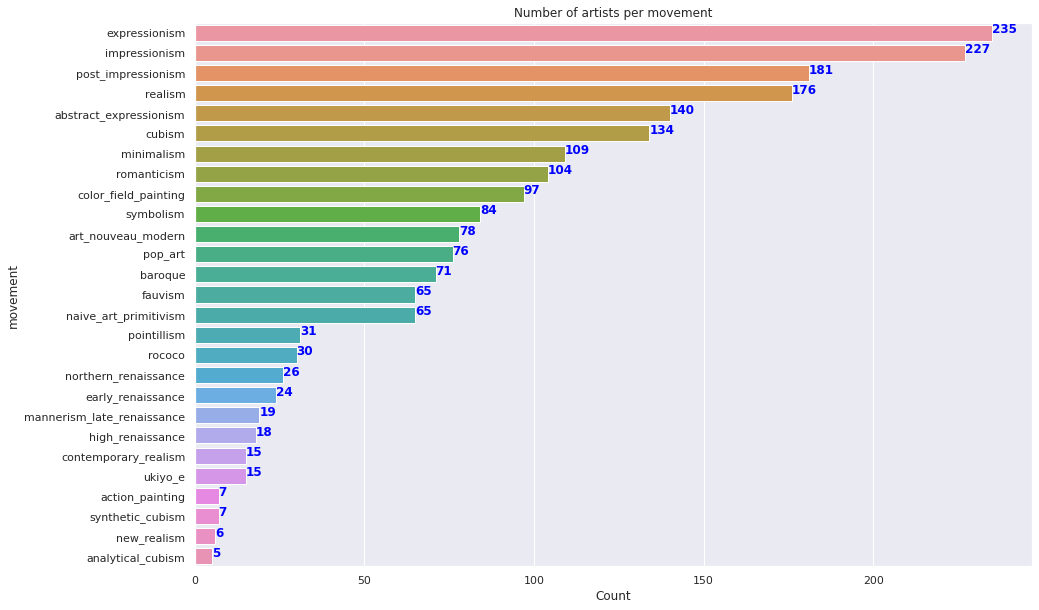

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.barplot(y=data.groupby("movement").artist.nunique().index, 
            x=data.groupby("movement").artist.nunique().values,
            order=data.groupby("movement").artist.nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data.groupby("movement").artist.nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of artists per movement");
ax.set_xlabel("Count");

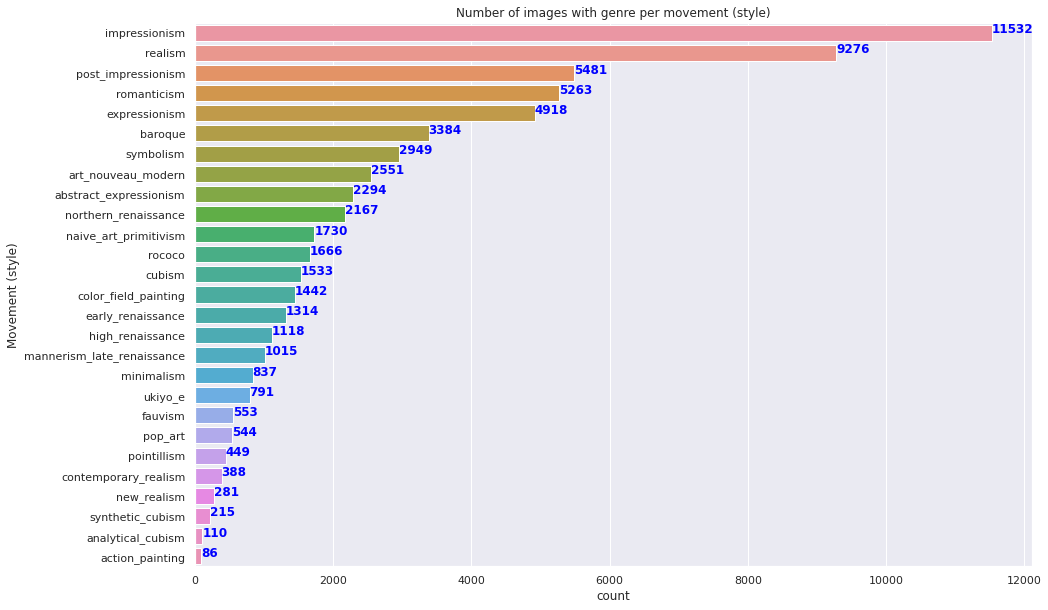

In [23]:
data2 = data[data["cs_split_genre"].notnull()]

fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data2, y="movement", 
              order = data2['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data2["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images with genre per movement (style)");
ax.set_ylabel("Movement (style)");

In [ ]:
data[data["cs-split-genre"].notnull()][data["movement"]=="Abstract_Expressionism"].head(100)

In [ ]:
def show_samples(df,sample_size=10):
    root_path='../raw_data/wikiart/wikiart/'
    artist=df['artist']
    movement=df['movement']
    title=df['title']
    folder_path=list(df['path'].sample(n=sample_size))
    complete_path=[root_path + i for i in folder_path]
    fig = plt.figure(constrained_layout=True,figsize=(10,5*sample_size))
    for i in list(range(0,sample_size)):
        plt.subplot(sample_size,1,i+1)
        image=plt.imread(complete_path[i])
        label=f'{movement[i]} - {title[i]} by {artist[i]}'
        plt.text(x=10,y=-2,s=label)
        plt.imshow(image)